## Importar Librerias y Funciones a utilizar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


def graficarPcorrelaciones(df, columns_name, annot=True, tamaño=(4,3),method='pearson'):
    # Seleccionar las columnas especificadas
    mat_corr = df[columns_name].corr(method)

    # Crear el gráfico
    plt.figure(figsize=tamaño)
    sns.heatmap(data=mat_corr, annot=annot, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)
    plt.title("Matriz de Correlación")
    plt.show()
# Transformador personalizado para reemplazar valores específicos por NaN

class ReplaceValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, values_to_replace):
        self.values_to_replace = values_to_replace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[X.isin(self.values_to_replace)] = np.nan
        return X

    def get_feature_names_out(self, input_features=None):
        # Devuelve los nombres de las columnas sin cambios, ya que no estamos haciendo una transformación estructural
        if input_features is None:
            return X.columns
        else:
            return input_features




# Transformador para eliminar filas con NaN
class DropNaTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[~np.isnan(X).any(axis=1)] # Convertimos a DataFrame para usar dropna()


class StartInOne(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Restamos 1 solo a las columnas de interés
        indices = [ i for i in range(X.shape[1]) if X[:,i].min() >0  ]
        X[:,indices] -= 1
        return X


## Procesar Datos

In [ ]:
df = pd.read_csv("datos/3428_num.csv",sep=";")


In [ ]:
selected_cols = ['P1', 'P2', 'P3_1', 'P3_2', 'P3_3', 'P3_4', 'P3_5', 'P4', 'P5', 'P6_1',
       'P6_2', 'P6_3', 'P7_1', 'P7_2', 'P7_3', 'P7_4', 'P7_5', 'P7_6', 'P7_7',
       'P8_1', 'P8_2', 'P8_3', 'P8_4', 'P9_1', 'P9_2', 'P9_3', 'P10_1',
       'P10_2', 'P10_3', 'P10_4', 'P11_1', 'P11_2', 'P11_3', 'P11_4', 'P11_5',
       'P14_1', 'P14_2', 'P14_3', 'P14_4', 'P14_5', 'P14_6', 'P17',
       'ESCFEMINIS']

In [ ]:
df = df[selected_cols]

In [ ]:
replace7 =['P9_1', 'P9_2', 'P9_3','P14_1', 'P14_2', 'P14_3', 'P14_4', 'P14_5', 'P14_6']
replace98_99 = ['P3_1', 'P3_2', 'P3_3', 'P3_4', 'P3_5', 'ESCFEMINIS']
replace789 =[col for col in selected_cols if col not in replace98_99]

### Tuberia

In [ ]:
# ColumnTransformer para convertir a nulos las opciones :  N.C., N.S. y No Procede
preprocessing = ColumnTransformer([
    ("re9899", ReplaceValuesTransformer([98, 99]), replace98_99),
    ("re789", ReplaceValuesTransformer([7,8, 9]),replace789),
    ],
    remainder='passthrough')

# Pipeline final
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("drop_na", DropNaTransformer()),
    ("subtract_one", StartInOne())
])
# para recupear el nombre de las columnas


## DataFrame Procesado

In [ ]:
dfProcesado = pd.DataFrame(pipeline.fit_transform(df),columns= preprocessing.get_feature_names_out())

In [ ]:
namesCols = [ col.replace('re9899__','').replace('re789__','') for col in preprocessing.get_feature_names_out()]

In [ ]:
dfProcesado.columns = namesCols

In [ ]:
dfProcesado.head()

,P3_1,P3_2,P3_3,P3_4,P3_5,ESCFEMINIS,P1,P2,P4,P5,...,P11_3,P11_4,P11_5,P14_1,P14_2,P14_3,P14_4,P14_5,P14_6,P17
0,10.0,0.0,10.0,10.0,10.0,8.0,1.0,0.0,0.0,2.0,...,2.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,10.0,10.0,10.0,10.0,10.0,8.0,0.0,0.0,1.0,2.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,8.0,6.0,7.0,9.0,9.0,7.0,0.0,1.0,2.0,2.0,...,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,5.0,4.0,5.0,8.0,3.0,5.0,1.0,1.0,2.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,4.0,4.0,5.0,7.0,10.0,0.0,1.0,0.0,1.0,...,3.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
df.shape,dfProcesado.shape

((4005, 43), (2344, 43))

 ## Variable dependiente para Regresor: **P3_3**
 P.3 A continuación voy a leerle algunos movimientos u organizaciones sociales y quisiera que me dijera qué grado de simpatía tiene hacia cada uno de ellos. Utilice, por favor, la escala de 0 a 10, sabiendo que 0 significa 'ninguna simpatía' y el 10 'mucha simpatía'.  
(ENTREVISTADOR/A: LEER CADA UNA DE LAS ORGANIZACIONES)  

**[P3]**  
| Movimiento/Organización         | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|----------------------------------|---|---|---|---|---|---|---|---|---|---|----|
| Ecologistas                      | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| Pacifistas                       | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| Feministas                       | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| Pro-derechos humanos             | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| Organizaciones LGTBIQ+           | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |


**Variables en escala likert**

In [ ]:
dfProcesado.columns[:7]

Index(['P3_1', 'P3_2', 'P3_3', 'P3_4', 'P3_5', 'ESCFEMINIS', 'P1'], dtype='object')

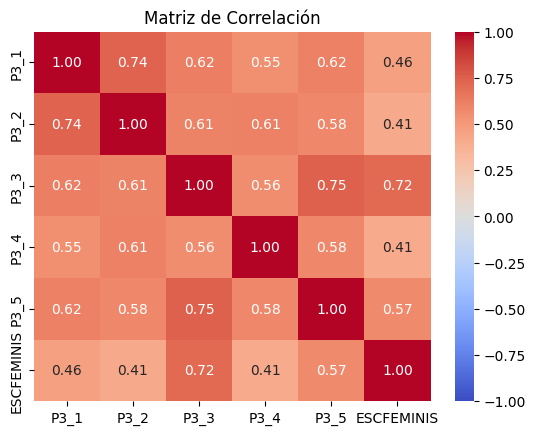

In [ ]:
likerts = list(dfProcesado.columns[:6])
dfCorr = dfProcesado[likerts].corr(method='spearman')
sns.heatmap(data=dfCorr, annot=True, fmt=".2f", cmap="coolwarm", center=0,vmin=-1,vmax=1)
plt.title("Matriz de Correlación")
plt.show()

## Entrenar Modelos

In [ ]:
from sklearn.model_selection import train_test_split

X = dfProcesado[likerts].drop('P3_3',axis=1)
y = dfProcesado['P3_3']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, random_state=1)

### Regresión Lineal

In [ ]:
import statsmodels.api as sm

def LinearRegWithBackwardElimination(X,y):
    while True:
      X_add_const = sm.add_constant(X)
      model_rl = sm.OLS(y, X_add_const)
      results  = model_rl.fit()
      # compruebo que NO haya betas no significativas
      if results.pvalues.max() < 0.05:
        break
      # eilimino betas no significativas
      vars = list(results.pvalues[results.pvalues<0.05].index)[1:]
      X = X[vars]

    return results

In [ ]:
result = LinearRegWithBackwardElimination(Xtrain,ytrain)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   P3_3   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1132.
Date:                Wed, 05 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:38:34   Log-Likelihood:                -3664.5
No. Observations:                1875   AIC:                             7339.
Df Residuals:                    1870   BIC:                             7367.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5895      0.133    -11.913      0.0

In [ ]:
vars = result.params.index[1:].tolist()
Xtrain = Xtrain[vars]
Xtest = Xtest[vars]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

folds = KFold(n_splits=10, shuffle=True, random_state=1)
scoreCV = -cross_val_score(estimator=LinearRegression(),
                          X=Xtrain,
                          y=ytrain,
                          cv=folds,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          verbose=1)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.1s finished


In [ ]:
print(scoreCV,"\n\n",scoreCV.mean(),scoreCV.std(),"\n\n")
print("intervalo (no estricto):",(scoreCV.mean()-1.96*scoreCV.std(),scoreCV.mean()+1.96*scoreCV.std()))

[2.64499855 3.12954817 2.70925842 3.07952804 2.96792766 2.4875774
 2.36567252 2.83767427 3.90370107 3.38541598] 

 2.951130207846042 0.4321260481742005 


intervalo (no estricto): (2.1041631534246092, 3.798097262267475)


In [ ]:
ECMRegLineal = mean_squared_error(ytest,result.predict(sm.add_constant(Xtest)))
ECMRegLineal

2.6318709718709474

In [ ]:
RMSE= {'LinearRegression':ECMRegLineal**(1/2)}

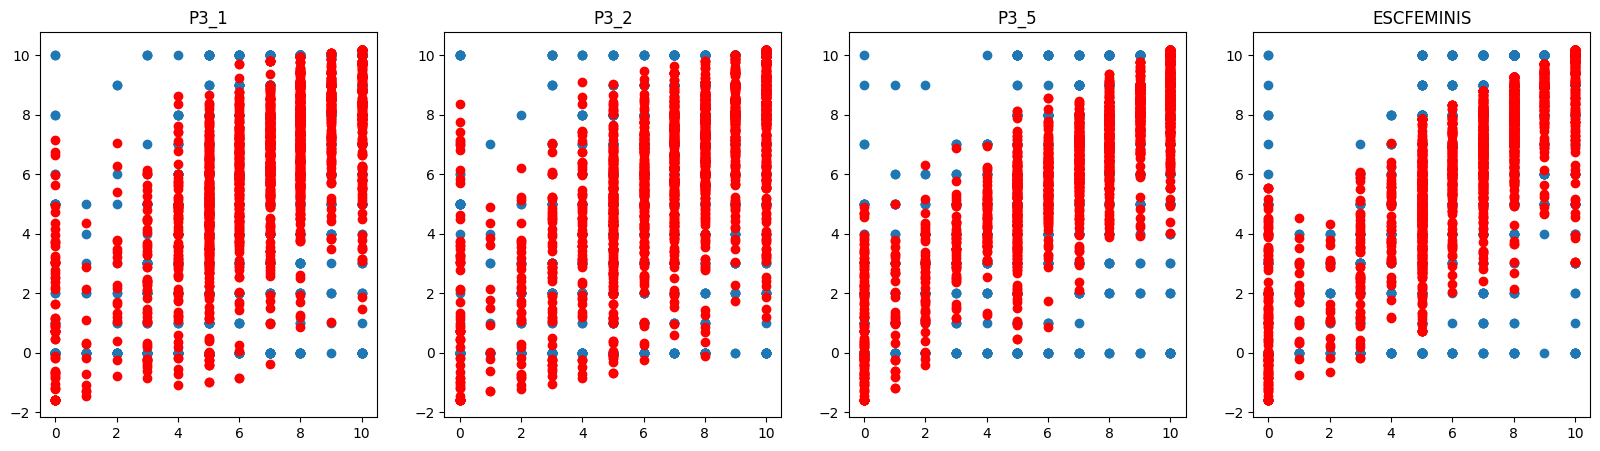

In [ ]:
fig,ax = plt.subplots(ncols=4,nrows=1,figsize=(20,5))

for i,var in enumerate(vars):
  ax[i].scatter(Xtrain[var],ytrain)
  ax[i].scatter(Xtrain[var],result.predict(sm.add_constant(Xtrain[vars])),color='red')
  ax[i].set_title(var)
plt.show()

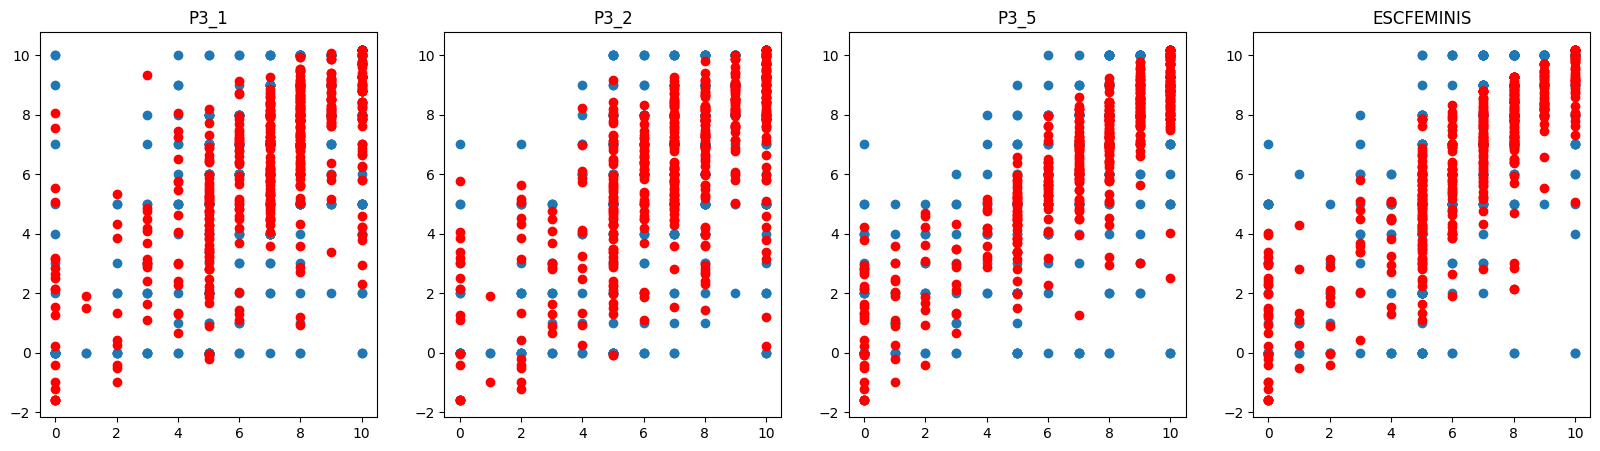

In [ ]:
fig,ax = plt.subplots(ncols=4,nrows=1,figsize=(20,5))

for i,var in enumerate(vars):
  ax[i].scatter(Xtest[var],ytest)
  ax[i].scatter(Xtest[var],result.predict(sm.add_constant(Xtest[vars])),color='red')
  ax[i].set_title(var)
plt.show()

### Bosques Aleatorios

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
param_grid = {
    'n_estimators': np.arange(1,50),
    'max_depth': [3],
    'max_features': ['sqrt']
}


kf = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid,
                           cv=kf,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           return_train_score=True)

In [ ]:
grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3], 'max_features': ['sqrt'],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
best_params = grid_search.best_params_
best_params

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 38}

In [ ]:
best_rf = grid_search.best_estimator_
best_rf

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=38)

In [ ]:
results = grid_search.cv_results_
cv_ecm = (-1)* results['mean_test_score']
train_ecm = (-1) * results['mean_train_score']


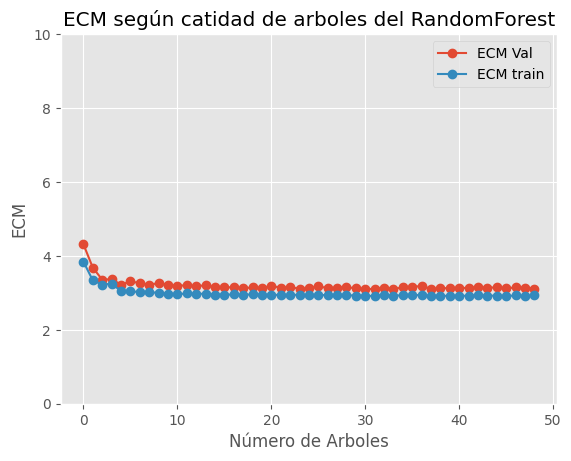

In [ ]:
plt.style.use("ggplot")
fig,ax=plt.subplots()
ax.plot(np.arange(cv_ecm.size),cv_ecm,marker="o",label='ECM Val')
ax.plot(np.arange(cv_ecm.size),train_ecm,marker="o",label='ECM train')

ax.set_title("ECM según catidad de arboles del RandomForest")
ax.set_xlabel("Número de Arboles")
ax.set_ylabel("ECM")
ax.set_ylim(0,10)
ax.legend()
plt.show()

In [ ]:
print("Error Cuadrático Medio: Intervalo para RandomForest")
print(cv_ecm.mean()+1.96*cv_ecm.std(),cv_ecm.mean()-1.96*cv_ecm.std())

Error Cuadrático Medio: Intervalo para RandomForest
3.5649525152110533 2.836143211391721


In [ ]:
print("Estimación puntual")
print(cv_ecm.mean())

Estimación puntual
3.200547863301387


In [ ]:
ypred = best_rf.predict(Xtest)
RForest = mean_squared_error(ytest,ypred)
RForest

2.7541540958920896

In [ ]:
RMSE['BestRandomForest'] = RForest**(1/2)

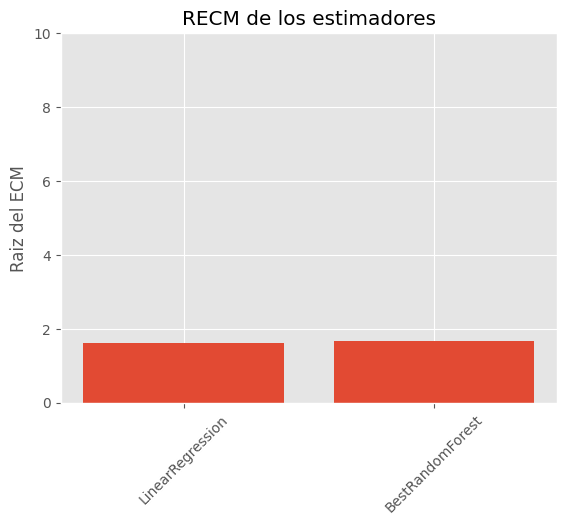

In [ ]:
fig,ax = plt.subplots()
ax.bar(x=list(RMSE.keys()),height=list(RMSE.values()))
ax.tick_params(axis='x',labelrotation=45)

ax.set_title("RECM de los estimadores")
ax.set_ylabel("Raiz del ECM")
ax.set_ylim(0,10)
plt.show()

### Redes Neuronales

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [ ]:
Xtrain,Xvalid,ytrain,yvalid = train_test_split(Xtrain,ytrain,test_size=.1,random_state=1)
scaler = StandardScaler(with_mean=True,with_std=True)
Xtrain = scaler.fit_transform(Xtrain)
Xvalid = scaler.fit_transform(Xvalid)
Xtest = scaler.fit_transform(Xtest)

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
model= keras.models.Sequential([
    keras.Input(shape=Xtrain.shape[1:]),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 30)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
history = model.fit(Xtrain,ytrain,epochs=20,validation_data=(Xvalid,yvalid))

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 48.0805 - val_loss: 25.6740
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.0132 - val_loss: 9.6942
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1162 - val_loss: 5.9276
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4099 - val_loss: 4.9687
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6504 - val_loss: 4.3392
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1476 - val_loss: 3.8603
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7818 - val_loss: 3.5122
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5238 - val_loss: 3.2665
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3420 - val_loss: 3.0899
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2113 - val_loss: 2.9629
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1122 - val_loss: 2.8637
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0362 - val

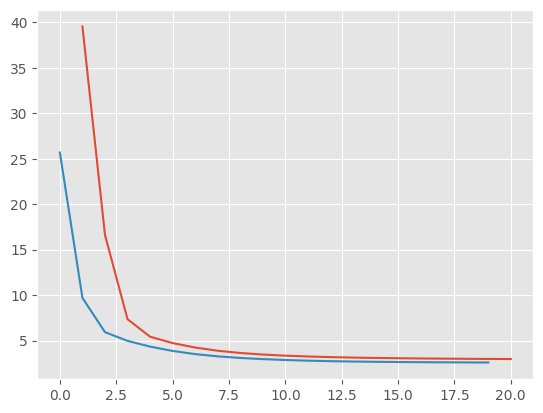

In [ ]:
loss = history.history['loss']
lossVal = history.history['val_loss']

fig,ax = plt.subplots()
ax.plot(np.arange(1,21),loss,lossVal)
plt.show()

**con 5 épocas es suficiente, ya que despues no hay mejora significativa**

In [ ]:
mse_test = model.evaluate(Xtest,ytest)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1432 


In [ ]:
RMSE['RedNeuronal'] = mse_test**(1/2)

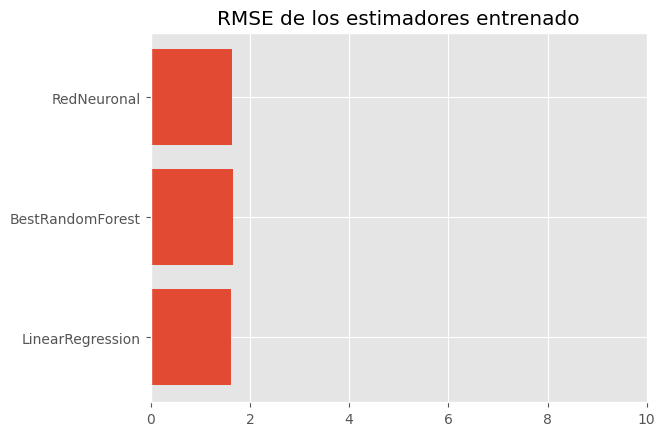

In [ ]:
fig,ax = plt.subplots()
ax.barh(y=RMSE.keys(),width=RMSE.values())
ax.set_title('RMSE de los estimadores entrenado')
ax.set_xlim(0,10)
plt.show()

In [ ]:
pd.Series(RMSE,name='Estimators').round(2).sort_values(ascending=True)

,Estimators
LinearRegression,1.62
RedNeuronal,1.65
BestRandomForest,1.66
